# Setup
Configure the notebook instance. Before you start using your notebook, you need to install the necessary packages:



In [ ]:
!curl -s https://course.fast.ai/setup/colab | bash


bash: line 1: syntax error near unexpected token `newline'
bash: line 1: `<!DOCTYPE html>'


In [ ]:
# Load the vision module contents within the fastai library
from fastai.vision import *
from fastai.tabular import *
import sklearn.metrics
import matplotlib.pyplot as plt
import pandas as pd
import os

In [ ]:
# Give Colab access to files in Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
#root_dir = "/content/gdrive/My Drive/"


In [ ]:
# set up matplotlib
%matplotlib inline

In [ ]:
# loss function

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def one_hot_embedding(labels, num_classes):
  """Embedding labels to one-hot form.

  Args:
    labels: (LongTensor) class labels, sized [N,].
    num_classes: (int) number of classes.

  Returns:
    (tensor) encoded labels, sized [N, #classes].
  """
  y = to_device(torch.eye(num_classes), device) 
  return y[labels] 

  
class SoftF1Loss(nn.Module):
  """ Fancy lossy boi - differentiable macro F1 score
  adapted from https://www.kaggle.com/backaggle/imet-fastai-starter-focal-and-fbeta-loss
  and https://towardsdatascience.com/the-unknown-benefits-of-using-a-soft-f1-loss-in-classification-systems-753902c0105d
  """
  def __init__(self):
    super().__init__()
    self.eps = 1e-7

  def forward(self, logits, labels, reduction='mean'):
    probs = F.softmax(logits, dim = -1)
    labels = one_hot_embedding(labels, num_classes = probs.shape[-1])
    # all sums are over examples (to return a result for each class)
    tp = torch.sum(probs * labels, dim=0)
    fp = torch.sum(probs * (1 - labels), dim=0)
    fn = torch.sum((1 - probs) * labels, dim=0)
    soft_f1 = 2 * tp / (2 * tp + fn + fp + self.eps)
    classwise_loss = 1 - soft_f1
    if reduction == 'mean':
      return torch.mean(classwise_loss)
    if reduction == 'sum':
      return torch.sum(classwise_loss)
    else:
      return classwise_loss

In [ ]:
# Specify the path to the RGB image files (provided by IDTReeS competition)
path_img = Path("/content/gdrive/My Drive/IDTReeS_2020/data/train_rgb_chips") 

# List the contents in the image path to make sure they were found properly
path_img.ls()

[PosixPath('/content/gdrive/My Drive/IDTReeS_2020/data/train_rgb_chips/LYLU3'),
 PosixPath('/content/gdrive/My Drive/IDTReeS_2020/data/train_rgb_chips/ACRU'),
 PosixPath('/content/gdrive/My Drive/IDTReeS_2020/data/train_rgb_chips/QUHE2'),
 PosixPath('/content/gdrive/My Drive/IDTReeS_2020/data/train_rgb_chips/BETUL'),
 PosixPath('/content/gdrive/My Drive/IDTReeS_2020/data/train_rgb_chips/QUAL'),
 PosixPath('/content/gdrive/My Drive/IDTReeS_2020/data/train_rgb_chips/QUCO2'),
 PosixPath('/content/gdrive/My Drive/IDTReeS_2020/data/train_rgb_chips/PEPA37'),
 PosixPath('/content/gdrive/My Drive/IDTReeS_2020/data/train_rgb_chips/QUNI'),
 PosixPath('/content/gdrive/My Drive/IDTReeS_2020/data/train_rgb_chips/QUGE2'),
 PosixPath('/content/gdrive/My Drive/IDTReeS_2020/data/train_rgb_chips/FAGR'),
 PosixPath('/content/gdrive/My Drive/IDTReeS_2020/data/train_rgb_chips/QULA2'),
 PosixPath('/content/gdrive/My Drive/IDTReeS_2020/data/train_rgb_chips/PITA'),
 PosixPath('/content/gdrive/My Drive/IDTReeS

# View data

In [ ]:
# set this value for consistent random sampling 
np.random.seed(42)

# create an ImageDataBunch using the RGB image chips
data = ImageDataBunch.from_folder(path_img, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(max_rotate=None), size=224, num_workers=4).normalize(imagenet_stats) #ds_tfms = get_transforms() 

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:541: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
PEPA37, QUNI
  if getattr(ds, 'warn', False): warn(ds.warn)


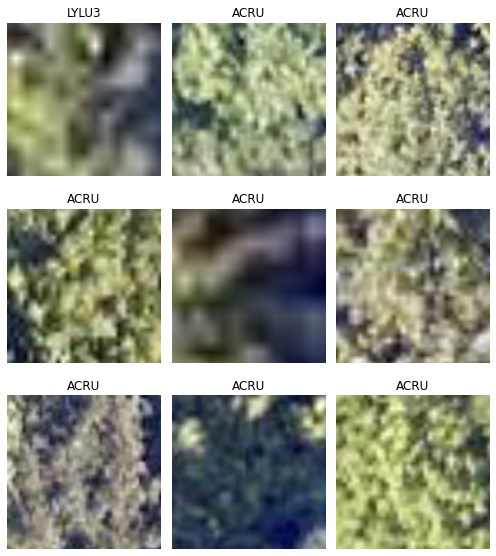

In [ ]:
# Take a look at some images with their respective class labels
data.show_batch(rows=3, figsize=(7,8), ds_type=DatasetType.Fix)

In [ ]:
# look at the first 10 rows, filename with extracted taxon label
data.train_ds.to_df().head(10)

,x,y
0,LYLU3/OSBS06152.jpg,LYLU3
1,ACRU/MLBS00423.jpg,ACRU
2,ACRU/MLBS00726.jpg,ACRU
3,ACRU/MLBS02081.jpg,ACRU
4,ACRU/MLBS00265.jpg,ACRU
5,ACRU/MLBS00729C.jpg,ACRU
6,ACRU/MLBS00662.jpg,ACRU
7,ACRU/MLBS02265.jpg,ACRU
8,ACRU/MLBS00754.jpg,ACRU
9,ACRU/MLBS01399B.jpg,ACRU


In [ ]:
# print the class names, number of classes, number of traning and validation images
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['ACPE',
  'ACRU',
  'ACSA3',
  'AMLA',
  'BETUL',
  'CAGL8',
  'CATO6',
  'FAGR',
  'GOLA',
  'LITU',
  'LYLU3',
  'MAGNO',
  'NYBI',
  'NYSY',
  'OXYDE',
  'PIEL',
  'PINUS',
  'PIPA2',
  'PITA',
  'PRSE2',
  'QUAL',
  'QUCO2',
  'QUERC',
  'QUGE2',
  'QUHE2',
  'QULA2',
  'QULA3',
  'QUMO4',
  'QURU',
  'ROPS',
  'TSCA'],
 31,
 846,
 206)

In [ ]:
# Count the number of samples per species class
vc = pd.value_counts(data.train_ds.y.items, sort=False)
vc.index = data.classes; 

vc

ACPE       5
ACRU     104
ACSA3      1
AMLA      38
BETUL      6
CAGL8      3
CATO6      1
FAGR       3
GOLA       1
LITU      16
LYLU3      1
MAGNO     12
NYBI       1
NYSY      33
OXYDE      9
PIEL       4
PINUS      6
PIPA2    237
PITA       3
PRSE2      6
QUAL      86
QUCO2     39
QUERC      1
QUGE2     15
QUHE2      3
QULA2     59
QULA3      1
QUMO4     10
QURU     138
ROPS       2
TSCA       2
dtype: int64

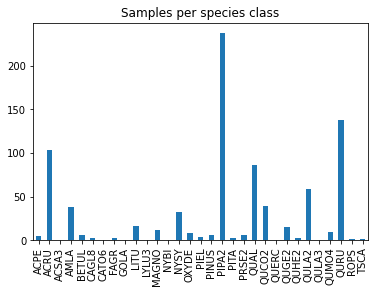

In [ ]:
# Bar plot showing the number of samples per class
vc.plot(kind='bar', title = "Samples per species class")

# Train model

In [ ]:
# train a convolutional neural network
learn = cnn_learner(data, 
                    models.resnet34, 
                    loss_func=SoftF1Loss(), 
                    metrics=[FBeta(beta=1, average='macro'), 
                                 accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.982831,0.976467,0.014663,0.063107,02:15
1,0.966874,0.946817,0.062764,0.262136,00:14
2,0.954142,0.934090,0.073600,0.305825,00:14
3,0.942172,0.932081,0.076125,0.325243,00:14
4,0.932607,0.931754,0.066855,0.330097,00:14


In [ ]:
learn.save('stage-1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


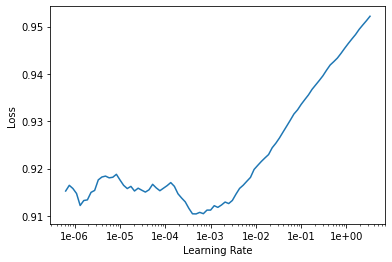

In [ ]:
# Show plot with loss as a function of learning rate
learn.recorder.plot()

In [ ]:
# How to get the ideal max_lr from the learn object? 
# Try a larger range w multiple orders of magnitude, (1e-5,1e-3)
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.919663,0.928113,0.079632,0.349515,00:15
1,0.908105,0.932196,0.065201,0.305825,00:15
2,0.898851,0.930511,0.074387,0.334951,00:15
3,0.889791,0.919534,0.086312,0.354369,00:15
4,0.883328,0.918095,0.086974,0.349515,00:15


In [ ]:
learn.save('stage-2')

# Write output species predictions to .csv file

In [ ]:
# the training set is a LabelList, with 846 images and corresponding labels.
data.train_ds

LabelList (846 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
LYLU3,ACRU,ACRU,ACRU,ACRU
Path: /content/gdrive/My Drive/IDTReeS_2020/data/train_rgb_chips

In [ ]:
# the validation set is a LabelList, with 211 images and corresponding labels.
# each label is an integer, corresponding to a species class 0 = ACPE, 1 = ACRU, ... 
# classes are listed and numbered alphabetically
data.valid_ds

LabelList (206 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
QUCO2,PIPA2,PIPA2,AMLA,ACRU
Path: /content/gdrive/My Drive/IDTReeS_2020/data/train_rgb_chips

In [ ]:
# look at the first image and label in the validation set.
# it's an image with dimensions (bands, rows, cols) 
# and a true species class label "Category" 
data.valid_ds[0]

(Image (3, 224, 224), Category 21)

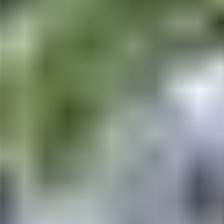

In [ ]:
# look an image in the validation set 
data.valid_ds[2][0]

In [ ]:
# supply the input image to the classifier and predict its species.
# the output has 3 parts: the predicted class, and a tensor with the 
# probability estimated per species class (or logit)
learn.predict(data.valid_ds[0][0])

(Category tensor(17),
 tensor(17),
 tensor([-3.0544e+00, -4.9429e-03, -1.3391e-01, -3.5666e+00,  2.6862e+00,
          1.0563e+00,  2.1776e+00, -1.3916e+00,  7.7401e-01,  2.7394e+00,
          1.5985e+00,  5.2332e-01, -4.9455e-01,  1.4345e+00,  2.0647e+00,
         -1.2852e+00,  2.8745e+00,  1.2528e+01, -4.5129e-01, -1.2487e+00,
          3.2487e+00, -6.4759e+00,  1.4008e+00, -1.9781e-01, -4.0273e+00,
          7.4269e-01,  1.4263e+00, -3.4935e+00,  2.5255e+00,  1.8318e-01,
          9.3218e-01]))

In [ ]:
# this code converts logits to probabilities, which sum to 1 
#torch.nn.functional.softmax(learn.predict(data.valid_ds[0][0])[2])
#sum(torch.nn.functional.softmax(learn.predict(data.valid_ds[0][0])[2]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


tensor([7.7498e-05, 1.0731e-03, 1.2389e-03, 7.4083e-05, 1.1981e-02, 5.8035e-03,
        5.3341e-03, 2.1028e-03, 4.9212e-04, 4.5001e-03, 7.1330e-03, 1.6397e-02,
        2.0019e-03, 5.7924e-04, 1.1775e-04, 5.8358e-01, 1.3449e-03, 4.6559e-04,
        8.0592e-05, 8.6811e-04, 8.1990e-02, 4.9061e-04, 2.5815e-01, 1.0132e-05,
        1.9363e-03, 1.5770e-04, 6.0205e-03, 3.6269e-06, 2.9371e-03, 1.3384e-03,
        1.0442e-04, 3.6846e-08, 4.2521e-04, 1.1908e-03])

In [ ]:
# check the length of that tensor, to make sure it has the same number of classes 
# as the training set used to train the classifier
print("Number of probability values in the predict output:")
len(learn.predict(data.valid_ds[0][0])[2])

Number of probability values in the predict output:


31

In [ ]:
# check the classes
print("Number of classes in our classifier:")
print(len(learn.data.classes))
print("Species classes:")
print(learn.data.classes)

Number of classes in our classifier:
31
Species classes:
['ACPE', 'ACRU', 'ACSA3', 'AMLA', 'BETUL', 'CAGL8', 'CATO6', 'FAGR', 'GOLA', 'LITU', 'LYLU3', 'MAGNO', 'NYBI', 'NYSY', 'OXYDE', 'PIEL', 'PINUS', 'PIPA2', 'PITA', 'PRSE2', 'QUAL', 'QUCO2', 'QUERC', 'QUGE2', 'QUHE2', 'QULA2', 'QULA3', 'QUMO4', 'QURU', 'ROPS', 'TSCA']


In [ ]:
# get the filename for each image,
# parse individual ID 
path_names = data.valid_ds.items
str(data.valid_ds.items[0]).split("/")[-1]

'MLBS01075.jpg'

In [ ]:
# create a data frame to store all of the important information:
#   individualID (unique for each individual tree) 
#   set ("eval", "train", "test")
#   estimated probability of each class species class

df_eval = pd.DataFrame({
 'indvdlID': ["nan"] * len(data.valid_ds),
 'set': ["eval"] * len(data.valid_ds)
 })

# make a column for each species and populate with the probability
for species in learn.data.classes:
  df_eval[ str(species)] = [0.0] * len(data.valid_ds)

# predict the species for each validation set image
for idx, test_image in enumerate(data.valid_ds):

    # get current individual id and add to the data frame
    indvdlID = os.path.splitext(str(data.valid_ds.items[idx]).split("/")[-1])[0]
    df_eval.at[idx, 'indvdlID'] = indvdlID

    # add species prediction logit for each class 
    df_eval.at[idx, learn.data.classes[0]:] = learn.predict(data.valid_ds[idx][0])[2].tolist()
    # add species prediction % for each class 
    #df_eval.at[idx, learn.data.classes[0]:] = torch.nn.functional.softmax(learn.predict(data.valid_ds[idx][0])[2], dim=0).tolist()

print(df_eval)

      indvdlID   set      ACPE  ...       QURU      ROPS      TSCA
0    MLBS01075  eval -3.054415  ...   2.525544  0.183178  0.932178
1    OSBS00824  eval -2.436877  ...  -0.345717 -0.112326  0.522675
2    OSBS01002  eval -1.870753  ...  -1.511137  0.154874  1.338815
3    MLBS01706  eval -2.094020  ...  -2.451680 -0.214179  2.456836
4    MLBS00752  eval -2.501459  ...   1.648193 -3.279241  1.449794
..         ...   ...       ...  ...        ...       ...       ...
201  MLBS01366  eval -1.804293  ...  -4.816077 -2.534430  1.440768
202  MLBS00462  eval  1.187753  ...   1.419894  0.465343 -0.784604
203  MLBS01525  eval -4.074441  ...  14.063317  0.604367  0.481298
204  OSBS00655  eval -0.767599  ...  -5.317420 -0.232590  0.348167
205  MLBS00444  eval -3.342552  ...   5.147257 -0.277602 -1.383834

[206 rows x 33 columns]


In [ ]:
# repeat for the training set, this time with "train" in the "set" column 
df_train = pd.DataFrame({
 'indvdlID': ["nan"] * len(data.train_ds),
 'set': ["train"] * len(data.train_ds)
 })

# make a column for each species and populate with the probability
for species in learn.data.classes:
  df_train[ str(species)] = [0.0] * len(data.train_ds)

# predict the species for each training set image
for idx, test_image in enumerate(data.train_ds):

    # get current individual id and add to the data frame
    indvdlID = os.path.splitext(str(data.train_ds.items[idx]).split("/")[-1])[0]
    df_train.at[idx, 'indvdlID'] = indvdlID

    # add species prediction logit for each class 
    df_train.at[idx, learn.data.classes[0]:] = learn.predict(data.train_ds[idx][0])[2].tolist()
    # add species prediction % for each class 
    #df_train.at[idx, learn.data.classes[0]:] = torch.nn.functional.softmax(learn.predict(data.train_ds[idx][0])[2], dim=0).tolist()

print(df_train)

      indvdlID    set      ACPE  ...      QURU      ROPS      TSCA
0    OSBS06152  train -2.697911  ...  4.185766 -0.129042  0.547517
1    MLBS00423  train -2.360241  ... -3.240506  0.993907  0.434240
2    MLBS00726  train -1.575352  ... -3.760876 -1.330282 -2.221045
3    MLBS02081  train -0.334148  ...  9.022920 -2.115569  2.724150
4    MLBS00265  train -0.840220  ...  2.772329 -0.333262 -0.727667
..         ...    ...       ...  ...       ...       ...       ...
841  MLBS01228  train -2.582084  ... -5.585845  0.956713  0.112105
842  MLBS01345  train -2.470089  ...  2.561613 -0.385447 -2.255885
843  MLBS01236  train  0.030859  ... -3.167686 -1.351247  1.328655
844  MLBS01383  train -1.998636  ... -6.378283 -1.566254  1.798569
845  OSBS01915  train  1.757496  ... -5.326339 -2.218532 -1.068538

[846 rows x 33 columns]


In [ ]:
# merge the eval and train data frames 
df = df_train.append(df_eval)

In [ ]:
# Specify output directory
path_out = Path("/content/gdrive/My Drive/IDTReeS_2020/output")
# Create the directory if it doesn't already exist
if not os.path.exists(path_out):
    os.makedirs(path_out)

In [ ]:
# write csv
# One row per tree, with ID and probabilities/logits associated with each class
filename_out = os.path.join(path_out, "rgb_predicted_species.csv")
df.to_csv(filename_out, 
          index = False)

print("Wrote class probabilities/logits to file: \n " + filename_out)


Wrote class probabilities/logits to file: 
 /content/gdrive/My Drive/IDTReeS_2020/output/rgb_predicted_species.csv


In [ ]:
# Export learner to file 
rgb_learner_fname = "/content/gdrive/My Drive/IDTReeS_2020/output/rgb_learner.pkl"
learn.export(rgb_learner_fname)

# Interpretation

In [ ]:

learn.load('stage-2');

NameError: ignored

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

NameError: ignored

In [ ]:
# Plot a confusion matrix to show the number of correct/incorrect 
# classifications per class
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Predict using Test set

In [ ]:
# Specify the path to the test RGB image files 
path_test_img = Path("/content/gdrive/My Drive/IDTReeS_2020/data/test_rgb_chips") 

# List the contents in the image path
path_test_img.ls()[0:5]

[PosixPath('/content/gdrive/My Drive/IDTReeS_2020/data/test_rgb_chips/MLBSE00106.jpg'),
 PosixPath('/content/gdrive/My Drive/IDTReeS_2020/data/test_rgb_chips/OSBSE00167.jpg'),
 PosixPath('/content/gdrive/My Drive/IDTReeS_2020/data/test_rgb_chips/OSBSE00680.jpg'),
 PosixPath('/content/gdrive/My Drive/IDTReeS_2020/data/test_rgb_chips/OSBSE00367.jpg'),
 PosixPath('/content/gdrive/My Drive/IDTReeS_2020/data/test_rgb_chips/OSBSE00038.jpg')]

In [ ]:
# read the learner object 
learn_obj = load_learner(path = "/content/gdrive/My Drive/IDTReeS_2020/output/",
                          file = "rgb_learner.pkl")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [ ]:
# read test images
test_data = ImageList.from_folder(path_test_img, extensions=['.jpg'], 
                                  recurse=False).split_none().label_empty().transform(tfms=get_transforms(max_rotate=None), size=224, tfm_y=False).databunch().normalize(imagenet_stats)

test_data.train_dl.new(shuffle=False)

test_data

ImageDataBunch;

Train: LabelList (585 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /content/gdrive/My Drive/IDTReeS_2020/data/test_rgb_chips;

Valid: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: /content/gdrive/My Drive/IDTReeS_2020/data/test_rgb_chips;

Test: None

In [ ]:
df_test = pd.DataFrame({
 'indvdlID': ["nan"] * len(test_data.train_ds),
 'set': ["test"] * len(test_data.train_ds)
 })

# make a column for each species and populate with the probability
for species in learn_obj.data.classes:
  df_test[ str(species)] = [0.0] * len(test_data.train_ds)

# predict the species for each validation set image
for idx, test_image in enumerate(test_data.train_ds):

    # get current individual id and add to the data frame
    indvdlID = os.path.splitext(str(test_data.train_ds.items[idx]).split("/")[-1])[0]
    df_test.at[idx, 'indvdlID'] = indvdlID

    # add species prediction logit for each class 
    df_test.at[idx, learn_obj.data.classes[0]:] = learn_obj.predict(test_data.train_ds[idx][0])[2].tolist()

print(df_test)

       indvdlID   set      ACPE  ...      QURU      ROPS      TSCA
0    MLBSE00106  test  3.570309  ...  0.214674  6.347930  0.532380
1    OSBSE00167  test -1.745283  ... -9.682433  0.915519  1.244447
2    OSBSE00680  test  4.641421  ... -9.342835 -2.000585 -0.013050
3    OSBSE00367  test  3.702651  ...  3.396103 -1.751599 -1.676783
4    OSBSE00038  test  2.493289  ...  0.399926  0.338159  1.898312
..          ...   ...       ...  ...       ...       ...       ...
580  OSBSE00178  test  0.810618  ... -0.857552  0.314214  0.428334
581  OSBSE00160  test  4.245896  ...  1.111566  1.296152 -0.758016
582  OSBSE00163  test  4.769516  ... -2.013891  5.582069 -2.010259
583  OSBSE00127  test  2.059417  ...  0.298689  0.975215  0.403657
584  OSBSE00201  test  4.876654  ...  1.357774  3.193158 -0.730520

[585 rows x 33 columns]


In [ ]:
# write logit predictions to file 

# One row per tree, with ID and probabilities/logits associated with each class
path_out = Path("/content/gdrive/My Drive/IDTReeS_2020/output")
filename_out = os.path.join(path_out, "rgb_predicted_species_TEST-IMGS.csv")
df_test.to_csv(filename_out, 
          index = False)

print("Wrote class probabilities/logits to file: \n " + filename_out)




Wrote class probabilities/logits to file: 
 /content/gdrive/My Drive/IDTReeS_2020/output/rgb_predicted_species_TEST-IMGS.csv


In [ ]:
# test: read csv exported from this Colab notebook
path_out = Path("/content/gdrive/My Drive/IDTReeS_2020/output")
filename_out = os.path.join(path_out, "rgb_predicted_species_TEST-IMGS.csv")
t = pd.read_csv(filename_out)
t

,indvdlID,set,ACPE,ACRU,ACSA3,AMLA,BETUL,CAGL8,CATO6,FAGR,GOLA,LITU,LYLU3,MAGNO,NYBI,NYSY,OXYDE,PIEL,PINUS,PIPA2,PITA,PRSE2,QUAL,QUCO2,QUERC,QUGE2,QUHE2,QULA2,QULA3,QUMO4,QURU,ROPS,TSCA
0,MLBSE00106,test,2.443444,3.365334,1.544947,-1.337718,-2.975542,1.232632,-0.083339,-1.260913,-0.728585,-2.253568,-0.832618,-2.852170,-0.375431,-2.904552,-0.317643,1.608739,-0.950561,-1.196945,-1.833170,-1.247311,0.422304,4.837006,-2.089550,1.606897,0.508498,-2.803282,0.383322,1.594327,5.402613,5.445750,-2.639436
1,OSBSE00167,test,-0.313252,-6.050187,2.425499,-1.105520,1.447832,-2.936404,-2.035750,-4.709078,1.713916,3.895493,0.707197,0.388884,1.959759,-2.195172,-4.142140,2.090633,1.302399,17.025738,-2.596209,1.681552,-5.336288,1.936890,0.402330,-1.529960,3.393140,-2.827128,3.430779,1.332912,-7.768491,-1.405112,0.938850
2,OSBSE00680,test,0.335036,-5.152166,0.133529,-1.068167,2.136545,-1.393160,0.645848,-2.214453,-0.433038,0.638330,0.047961,-1.406341,0.803230,-6.078926,-1.412510,0.331295,0.574540,17.630951,-2.661620,0.041241,-1.752521,2.429854,1.902947,4.792353,0.455187,0.674556,3.413160,-2.321852,-9.452295,-0.515677,0.402519
3,OSBSE00367,test,-1.642960,-6.452141,0.341097,-3.167321,2.020093,-1.943810,1.446110,-3.007372,-0.863338,-1.373853,0.420095,-0.846620,1.538054,-5.190985,-2.537466,0.861125,-0.707787,11.462483,-0.854385,-0.772590,-6.484025,1.512681,1.003763,4.892976,3.804621,6.807936,2.410796,-5.305136,0.137482,-1.312746,-1.026778
4,OSBSE00038,test,2.048771,-4.588718,1.112030,-0.819222,-0.524459,0.083406,-0.329746,-1.661743,-0.868584,-0.195895,-1.287024,-0.753534,1.193837,-4.657523,-3.029450,1.401700,-0.592772,6.340067,-0.256209,-0.554632,0.281701,1.104766,0.871248,0.662192,2.182229,5.675213,0.500886,-0.765837,0.720083,-1.199970,0.580589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,OSBSE00178,test,0.961554,-0.322844,0.382750,1.241698,-1.823610,-1.008533,-2.102785,-3.252602,0.928846,4.446304,2.601039,2.326012,1.340332,1.291509,-0.545405,0.708681,0.536031,6.535871,0.528970,-1.233619,0.700192,-2.475328,-1.661629,-1.462092,2.346276,-5.435536,0.368130,5.039993,-4.548432,0.191465,0.196186
581,OSBSE00160,test,-0.363792,11.385491,0.359939,3.597513,-1.930215,-0.066466,-1.199382,4.004467,-1.453369,-1.537101,-0.905166,-0.064494,0.386939,0.256331,-2.877339,3.272342,-0.988210,-7.994281,1.550120,0.385299,3.148107,1.994712,-0.364809,-3.416411,-0.629306,-0.355382,-1.444720,1.678257,-7.712486,3.890842,-0.871638
582,OSBSE00163,test,4.863425,5.640903,1.930150,1.923155,-1.967636,0.039731,-0.495234,2.116582,-1.689903,-1.559403,-1.066667,-0.910646,-1.453916,-0.654672,-2.050278,1.120951,-0.479661,-8.968802,0.137682,1.063766,4.210107,9.025467,-1.318738,-0.513627,-0.667999,-3.092605,-1.823562,0.694995,1.003448,1.994217,-3.827555
583,OSBSE00127,test,1.337375,-3.180533,-3.207460,1.642929,-1.204063,-1.400315,1.438163,-1.408267,-0.020116,-2.400987,2.192902,-1.667363,-0.230198,2.377108,1.244552,-0.665030,0.695758,11.799949,1.919644,-1.479884,1.104742,-2.648374,0.978127,-1.376698,-1.326061,3.952485,0.953775,-1.762196,-4.982112,0.224072,0.130734
